# Circuit learning module: Lambeq's QuantumTrainer

This module performs the optimization with Lambeq's native optimizer. Because the circuits are constructed with Lambeq and DisCoPy, this optimizer is the natural choice. The code is based on the workflow presented in https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline.ipynb.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import glob
from pathlib import Path
import numpy as np
import pickle

from discopy.utils import loads
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"
small = True

BATCH_SIZE = 32
EPOCHS = 1000
SEED = 0

## Read circuit data

We read the circuits from the pickled files.

In [2]:
training_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//training//[0-9]*.p")
validation_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//validation//[0-9]*.p")
test_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//test//[0-9]*.p")

training_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//small//circuits//binary_classification//training//[0-9]*.p")
validation_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//small//circuits//binary_classification//validation//[0-9]*.p")
test_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//small//circuits//binary_classification//test//[0-9]*.p")

def read_diagrams(circuit_paths):
    circuits = {}
    for serialized_diagram in circuit_paths:
        base_name = Path(serialized_diagram).stem
        f = open(serialized_diagram, "rb")
        diagram = pickle.load(f)
        circuits[base_name] = diagram
    return circuits


training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [3]:
training_data, test_data, validation_data = None, None, None
if small:
    with open(this_folder + "//data//small//training_data.json", "r") as inputfile:
        training_data = json.load(inputfile)['training_data']
    with open(this_folder + "//data//small//test_data.json", "r") as inputfile:
        test_data = json.load(inputfile)['test_data']
    with open(this_folder + "//data//small//validation_data.json", "r") as inputfile:
        validation_data = json.load(inputfile)['validation_data']
else:
    with open(this_folder + "//data//training_data.json", "r") as inputfile:
        training_data = json.load(inputfile)['training_data']
    with open(this_folder + "//data//test_data.json", "r") as inputfile:
        test_data = json.load(inputfile)['test_data']
    with open(this_folder + "//data//validation_data.json", "r") as inputfile:
        validation_data = json.load(inputfile)['validation_data']
    

def time_to_states(data, circuits):
    labeled_data = {}
    for elem in data:
        if elem["name"] in circuits.keys():
            if elem["time"] < 1062:
                labeled_data[elem["name"]] = [1,0] # corresponds to |0>
            else:
                labeled_data[elem["name"]] = [0,1] # corresponds to |1>
    return labeled_data


training_data_labels = time_to_states(training_data, training_circuits)
test_data_labels = time_to_states(test_data, test_circuits)
validation_data_labels = time_to_states(validation_data, validation_circuits)

#for key in training_data_labels:
#    print("training: ", key)
#for key in test_data_labels:
#    print("test ", key)

## Lambeq optimizer

In [4]:
#all_circuits = list(training_circuits.values()) + list(test_circuits.values())

training_circuits_l = []
test_circuits_l = []
validation_circuits_l = []

training_data_labels_l = []
test_data_labels_l = []
validation_data_labels_l = []

# Organize circuits and labels in correct order into two lists which will be input for training the model
for key in training_data_labels:
    training_circuits_l.append(training_circuits[key])
    training_data_labels_l.append(training_data_labels[key])

for key in test_data_labels:
    test_circuits_l.append(test_circuits[key])
    test_data_labels_l.append(test_data_labels[key])
    
for key in validation_data_labels:
    validation_circuits_l.append(validation_circuits[key])
    validation_data_labels_l.append(validation_data_labels[key])

all_circuits = training_circuits_l + test_circuits_l + validation_circuits_l

train_syms = set([sym for circuit in training_circuits.values() for sym in circuit.free_symbols])
test_syms = set([sym for circuit in test_circuits.values() for sym in circuit.free_symbols])
val_syms = set([sym for circuit in validation_circuits.values() for sym in circuit.free_symbols])

print("Test circuits need to share training circuits' parameters. The parameters that are not covered: ", test_syms.difference(train_syms))
print("Validation circuits need to share training circuits' parameters. The parameters that are not covered: ", val_syms.difference(train_syms))

print("Total number of circuits: ", len(all_circuits))
print("Total number of variables: ", len(train_syms))

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 3276
}

Test circuits need to share training circuits' parameters. The parameters that are not covered:  {id__n.l_2, production_year__n.l_2, id__n.l_1, movie_keyword__n.l_1, production_year__n.l_0, title__n.l_1, 2011__n.l_1, id__n.l_0, title__n.l_0, production_year__n.l_1, <_n.l@n.l_n.l_0, 2011__n.l_0, 2011__n.l_2, movie_keyword__n.l_0, title__n.l_2, movie_keyword__n.l_2}
Validation circuits need to share training circuits' parameters. The parameters that are not covered:  {2004__n.l_1, id__n.l_2, production_year__n.l_2, id__n.l_1, >_n.l@n.l_n.l_0, 2004__n.l_2, production_year__n.l_0, title__n.l_1, title__n.l_0, production_year__n.l_1, id__n.l_0, title__n.l_2, 2004__n.l_0}
Total number of circuits:  9
Total number of variables:  53


## Model

Select the used model between `TketModel` or `NumpyModel`. `NumpyModel` can use JAX which speeds up the training.

In [5]:
model = TketModel.from_diagrams(training_circuits_l, backend_config=backend_config)
#model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
model.initialise_weights()

## Loss function and evaluation

In [6]:
def acc(y_hat, y):
    return (np.sum(np.round(y_hat) == y) / len(y)) / 2

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)

eval_metrics = {"acc": acc}

## Trainer

In [7]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.91, 'c': 0.12, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

## Training dataset

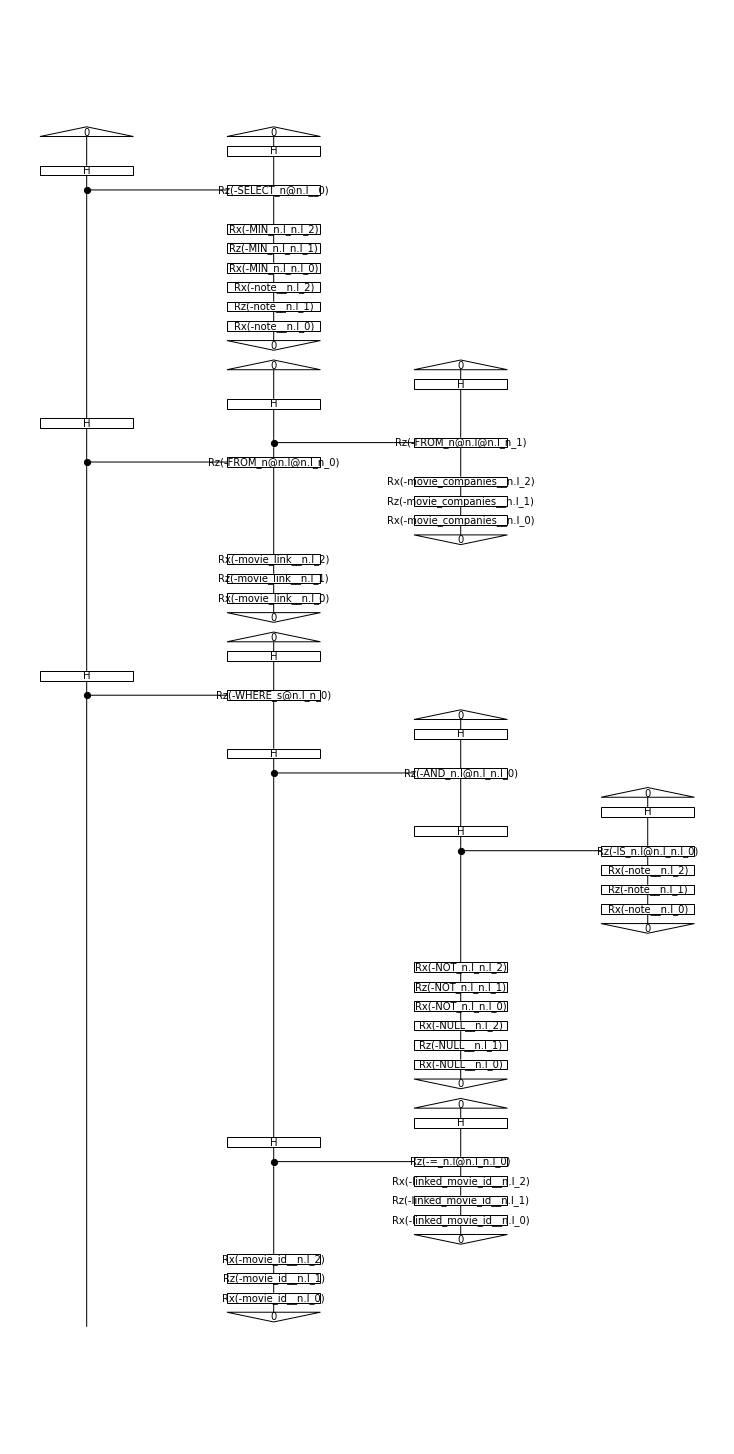

[0.5483089773027511, 0.45169102269724903] AND_n.l@n.l_n.l_0
[0.6610172497814744, 0.3389827502185257] linked_movie_id__n.l_2
[0.3060604458180028, 0.6939395541819972] MIN_n.l_n.l_0
[0.5670497546264199, 0.43295024537358] movie_id__n.l_0
[0.5604163586471025, 0.43958364135289746] linked_movie_id__n.l_1
[0.39345990475445203, 0.606540095245548] NULL__n.l_2
[0.29203006839212114, 0.7079699316078789] movie_link__n.l_2
[0.3466158846966481, 0.6533841153033519] FROM_n@n.l@n.l_n_0
[0.39060333575057954, 0.6093966642494205] NOT_n.l_n.l_1
[0.23433479208018082, 0.7656652079198192] note__n.l_1
[0.3450751642949187, 0.6549248357050812] SELECT_n@n.l__0
[0.7267978166715545, 0.2732021833284455] =_n.l@n.l_n.l_0
[0.17400550591331773, 0.8259944940866822] movie_link__n.l_1
[0.4386969450308287, 0.5613030549691714] linked_movie_id__n.l_0
[0.4877742225695626, 0.5122257774304374] NOT_n.l_n.l_2
[0.6283934187087988, 0.3716065812912011] MIN_n.l_n.l_2
[0.5536695677503607, 0.4463304322496393] movie_companies__n.l_1
[0.673

In [8]:
#print(training_data_labels_l)
#for c in training_circuits_l:
#    c.draw(figsize=(10, 20))

from discopy.quantum import Circuit
import numpy
import copy
SEED = 10
rng = numpy.random.default_rng(SEED)
c = training_circuits_l[0].dagger()
c.draw(figsize=(10, 20))
parameter_n = len(c.free_symbols)
params = list(c.free_symbols)
c = c.lambdify(*params)
x00 = -np.array(rng.random(parameter_n))
numpy.random.seed(SEED)
#for x in x00: print(x)

#for i in range(len(params)):
#    print(i, params[i])

def normalise(predictions):
    # apply smoothing to predictions
    predictions = np.abs(predictions) + 1e-9
    return predictions / predictions.sum()

for i in range(31):
    #c.draw(figsize=(10, 20))
    x0 = copy.deepcopy(x00)
    #print(x0)
    x0[i] = x0[i] + 0.7
    #print(x0)
    outputs = Circuit.eval(c(*x0))
    print(list(normalise(outputs.array)), params[i])

In [9]:
train_dataset = Dataset(training_circuits_l, training_data_labels_l)
val_dataset = Dataset(validation_circuits_l, validation_data_labels_l, shuffle=False)
test_dataset = Dataset(test_circuits_l, test_data_labels_l, shuffle=False)

trainer.fit(train_dataset, evaluation_step=1, logging_step=100)

Epoch 1:     train/loss: 0.6016   valid/loss: -----   train/acc: 0.8333   valid/acc: -----
Epoch 100:   train/loss: 3.2280   valid/loss: -----   train/acc: 0.3333   valid/acc: -----
Epoch 200:   train/loss: 0.5043   valid/loss: -----   train/acc: 0.8333   valid/acc: -----
Epoch 300:   train/loss: 0.5430   valid/loss: -----   train/acc: 0.6667   valid/acc: -----
Epoch 400:   train/loss: 0.6931   valid/loss: -----   train/acc: 0.5000   valid/acc: -----
Epoch 500:   train/loss: 2.9242   valid/loss: -----   train/acc: 0.6667   valid/acc: -----
Epoch 600:   train/loss: 0.8175   valid/loss: -----   train/acc: 0.3333   valid/acc: -----
Epoch 700:   train/loss: 0.5100   valid/loss: -----   train/acc: 0.6667   valid/acc: -----
Epoch 800:   train/loss: 0.7607   valid/loss: -----   train/acc: 0.3333   valid/acc: -----
Epoch 900:   train/loss: 0.4621   valid/loss: -----   train/acc: 0.6667   valid/acc: -----
Epoch 1000:  train/loss: 0.6124   valid/loss: -----   train/acc: 0.5000   valid/acc: -----

53


NameError: name 'id__n' is not defined

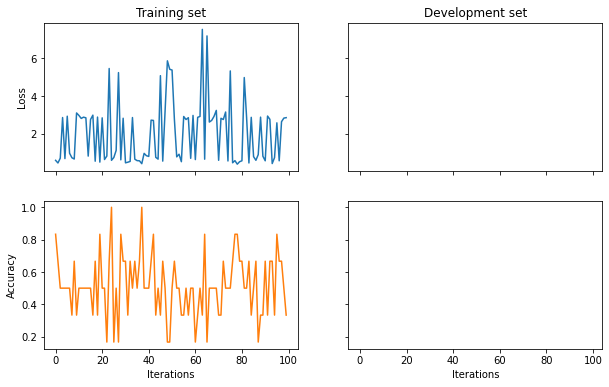

In [10]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

print(len(model.weights))

for e in model(test_circuits_l):
    print(e)
for e in test_data_labels_l:
    print(e)

# print test accuracy
test_acc = acc(model(test_circuits_l), test_data_labels_l)
print('Test accuracy:', test_acc.item())